## Cell subsampling using TopACeDo

In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.20.1'

time: 4.16 s (started: 2022-08-15 13:32:09 +02:00)


---
### 1) Installing dependencies

We need to install the TopACeDo algorithm to perform subsampling:

In [2]:
!pip install git+https://github.com/fraenkel-lab/pcst_fast.git@deb3236cc26ee9fee77d5af40fac3f12bb753850
!pip install -U topacedo

  Cloning https://github.com/fraenkel-lab/pcst_fast.git (to revision deb3236cc26ee9fee77d5af40fac3f12bb753850) to c:\users\parashar\appdata\local\temp\pip-req-build-udgz2nxs
  Resolved https://github.com/fraenkel-lab/pcst_fast.git to commit deb3236cc26ee9fee77d5af40fac3f12bb753850
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pcst-fast: filename=pcst_fast-1.0.7-cp39-cp39-win_amd64.whl size=81553 sha256=2c266b428fcdcd3baa167b5d9d17546e1b98e4e026810fd420a94fd354738f69
  Stored in directory: c:\users\parashar\appdata\local\pip\cache\wheels\24\93\f9\d568bfdad0da824c0593454ab71b9700b65c88f379f68d0453
Successfully built pcst-fast


  Running command git clone --filter=blob:none --quiet https://github.com/fraenkel-lab/pcst_fast.git 'C:\Users\parashar\AppData\Local\Temp\pip-req-build-udgz2nxs'
  Running command git rev-parse -q --verify 'sha^deb3236cc26ee9fee77d5af40fac3f12bb753850'
  Running command git fetch -q https://github.com/fraenkel-lab/pcst_fast.git deb3236cc26ee9fee77d5af40fac3f12bb753850
  Running command git checkout -q deb3236cc26ee9fee77d5af40fac3f12bb753850


time: 17.4 s (started: 2022-08-15 13:32:13 +02:00)


---
### 2) Fetching pre-processed data

In [3]:
# Loading preanalyzed dataset that was processed in the `basic_tutorial` vignette
scarf.fetch_dataset(
    dataset_name='tenx_5K_pbmc_rnaseq',
    as_zarr=True, 
    save_path='scarf_datasets'
)

time: 11.7 s (started: 2022-08-15 13:32:30 +02:00)


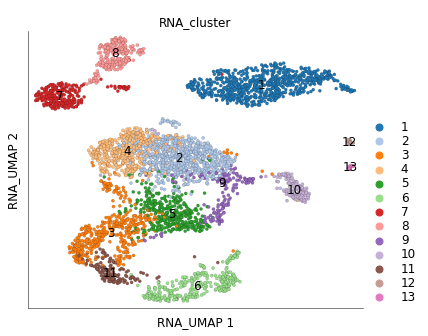

time: 2.91 s (started: 2022-08-15 13:32:42 +02:00)


In [4]:
ds = scarf.DataStore('scarf_datasets/tenx_5K_pbmc_rnaseq/data.zarr')

ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_cluster'
)

---
### 3) Run TopACeDo downsampler

UMAP, clustering and marker identification together allow a good understanding of cellular diversity. However, one can still choose from a plethora of other analysis on the data. For example, identification of cell differentiation trajectories. One of the major challenges to run these analysis could be the size of the data. Scarf performs a topology conserving downsampling of the data based on the cell neighbourhood graph. This downsampling aims to maximize the heterogeneity while sampling cells from the data.

Here we run the TopACeDo downsampling algorithm that leverages Scarf's KNN graph to perform a manifold preserving subsampling of cells. The subsampler can be invoked directly from Scarf's DataStore object.

In [5]:
ds.run_topacedo_sampler(
    cluster_key='RNA_cluster',
    max_sampling_rate=0.1
)

Constructing graph from dendrogram: 100%|█| 3939/3939 [00:00<00:00, 102

INFO: 384 cells (9.75%) sub-sampled. Subsample to Seed (165 cells) ratio: 2.327
time: 1.75 s (started: 2022-08-15 13:32:45 +02:00)


As a result of subsampling the subsampled cells are marked True under the cell metadata column `RNA_sketched`. We can visualize these cells using `plot_layout`

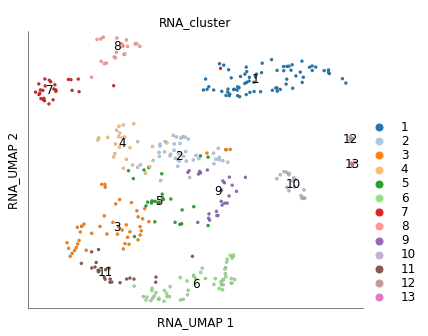

time: 344 ms (started: 2022-08-15 13:32:47 +02:00)


In [6]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_cluster',
    subselection_key='RNA_sketched'
)

It may also be interesting to visualize the cells that were marked as `seed cells` used when PCST was run. These cells are marked under the column `RNA_sketch_seeds`.

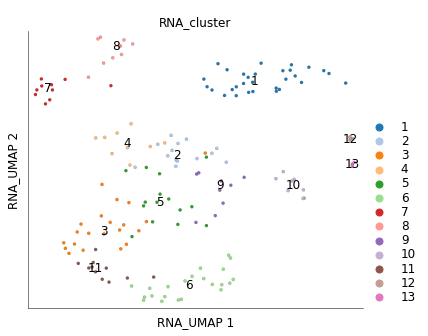

time: 328 ms (started: 2022-08-15 13:32:47 +02:00)


In [7]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_cluster', 
    subselection_key='RNA_sketch_seeds'
)

---
### 4) Intermediate parameters of downsampling

To identify the seed cells, the subsampling algorithm calculates cell densities based on neighbourhood degrees. Regions of higher cell density get a sampling penalty. The neighbourhood degree of individual cells are stored under the column `RNA_cell_density`.

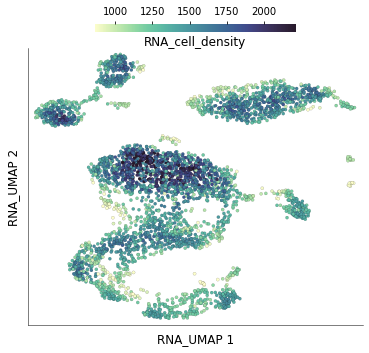

time: 500 ms (started: 2022-08-15 13:32:48 +02:00)


In [8]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_cell_density'
)

The dowsampling algorithm also identifies regions of the graph where cells form tightly connected groups by calculating mean shared nearest neighbours of each cell's nieghbours. The tightly connected regions get a sampling award. These values can be accessed from under the cell metadata column `RNA_snn_value`.

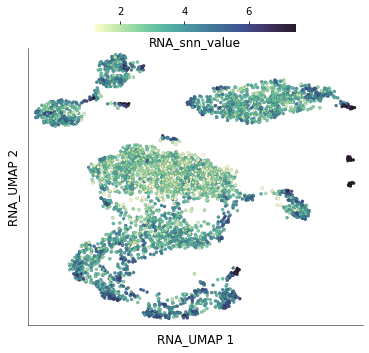

time: 500 ms (started: 2022-08-15 13:32:48 +02:00)


In [9]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_snn_value'
)

---
### 5) Exporting downsampled data

In [14]:
writer = scarf.SubsetZarr(
    in_zarr='scarf_datasets/tenx_5K_pbmc_rnaseq/data.zarr',
    out_zarr='scarf_datasets/tenx_5K_pbmc_rnaseq/subset.zarr',
    cell_key='RNA_sketched',
    reset_cell_filter=False,
)
writer.dump()

Subsetting assay: RNA:   0%|                                                                                  …

time: 1.8 s (started: 2022-08-15 13:37:11 +02:00)


In [15]:
ds2 = scarf.DataStore('scarf_datasets/tenx_5K_pbmc_rnaseq/subset.zarr')

(RNA) Computing nCells and dropOuts:   0%|                                                                    …

(RNA) Computing RNA_percentMito:   0%|                                                                        …

(RNA) Computing RNA_percentRibo:   0%|                                                                        …

time: 1.03 s (started: 2022-08-15 13:37:29 +02:00)


In [17]:
ds2

DataStore has 384 (384) cells with 1 assays: RNA
   Cell metadata:
            'I', 'ids', 'names', 'RNA_UMAP1', 'RNA_UMAP2', 
            'RNA_cell_density', 'RNA_cluster', 'RNA_leiden_cluster', 'RNA_nCounts', 'RNA_nFeatures', 
            'RNA_percentMito', 'RNA_percentRibo', 'RNA_sketch_seeds', 'RNA_sketched', 'RNA_snn_value', 
            'RNA_tSNE1', 'RNA_tSNE2'
   RNA assay has 8773 (33538) features and following metadata:
            'I', 'ids', 'names', 'dropOuts', 'nCells', 
          

time: 31 ms (started: 2022-08-15 13:37:39 +02:00)


In [22]:
adata = ds2.to_anndata()

INFO: Converting raw data from RNA assay into CSR format:   0%|                                               …

time: 468 ms (started: 2022-08-15 13:38:42 +02:00)


C:\Users\parashar\miniconda3\envs\scarf\lib\site-packages\scarf\datastore.py:4341: FutureWarning: X.dtype being converted to np.float32 from uint32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(assay.to_raw_sparse(cell_key), obs=obs, var=var)
C:\Users\parashar\miniconda3\envs\scarf\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [23]:
adata

AnnData object with n_obs × n_vars = 384 × 33538
    obs: 'I', 'names', 'RNA_UMAP1', 'RNA_UMAP2', 'RNA_cell_density', 'RNA_cluster', 'RNA_leiden_cluster', 'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 'RNA_percentRibo', 'RNA_sketch_seeds', 'RNA_sketched', 'RNA_snn_value', 'RNA_tSNE1', 'RNA_tSNE2'
    var: 'I', 'gene_ids', 'dropOuts', 'nCells'

time: 16 ms (started: 2022-08-15 13:38:43 +02:00)


---
That is all for this vignette.